# Interpret the Embedding Space

**helical-ai:** Analyze the effects of the perturbations by visualizing and interpreting the resulting
embedding space. Consider metrics such as clustering, shifts in embedding coordinates,
and neighborhood analysis to infer the impact of perturbations on tumor gene networks.

**Titouan:** Since I spent so much time on step 2, I didn't have as much time as I would have liked for this step. I decided to get a general look at the embeddings using UMAP first and then t-SNE. Next, I trained a KNN algorithm on the tumor and healthy tissues and evaluated how it predicted the perturbed healthy and tumor states. If the algorithm predicted the healthy perturbed samples as tumor and the tumor perturbed samples as healthy, it would be a good indication that our in-silico perturbation was somewhat successful.

## 1) Imports

In [1]:
import umap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

2024-12-03 17:48:30.797008: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 17:48:30.813437: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 17:48:30.824954: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 17:48:30.828313: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 17:48:30.836803: I tensorflow/core/platform/cpu_feature_guar

## 2) Loading embeddings & metadata

In [2]:
embeddings = np.load("embeddings.npy")
embeddings

array([[-0.00152033,  0.00857751,  0.06852891, ..., -0.01273486,
        -0.0053502 , -0.03958685],
       [-0.01209087,  0.00812419,  0.08059379, ..., -0.00642472,
         0.00311027, -0.04242285],
       [-0.03827563, -0.02448463,  0.06833865, ..., -0.04742155,
         0.03480127, -0.05131922],
       ...,
       [-0.01957471, -0.01962318,  0.06823943, ..., -0.03117719,
         0.00642839, -0.03632931],
       [-0.0324485 , -0.02102665,  0.04771277, ..., -0.01398094,
         0.02815565, -0.02868117],
       [-0.04091785, -0.01616941,  0.05389525, ..., -0.0321766 ,
         0.01301332, -0.03640614]], dtype=float32)

In [3]:
tissue_info = pd.read_csv("embedding_tissue_info.csv", index_col=0)
tissue_info

,tissue
0,3
1,3
2,1
3,3
4,0
...,...
995,3
996,3
997,1
998,2


## 3) Umap

Let's use umap to get a better look at what our final embeddings look like.

In [4]:
reducer = umap.UMAP(min_dist=0.2, n_components=2, n_epochs=None,n_neighbors=3)
mapper = reducer.fit(embeddings)

/tmp/ipykernel_6701/67034965.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data = plot_df,x='px',y='py',sizes=(50,200),ax=axs[0],palette="pastel")


Text(0.5, 1.0, 'UMAP of Reference Data with labels')

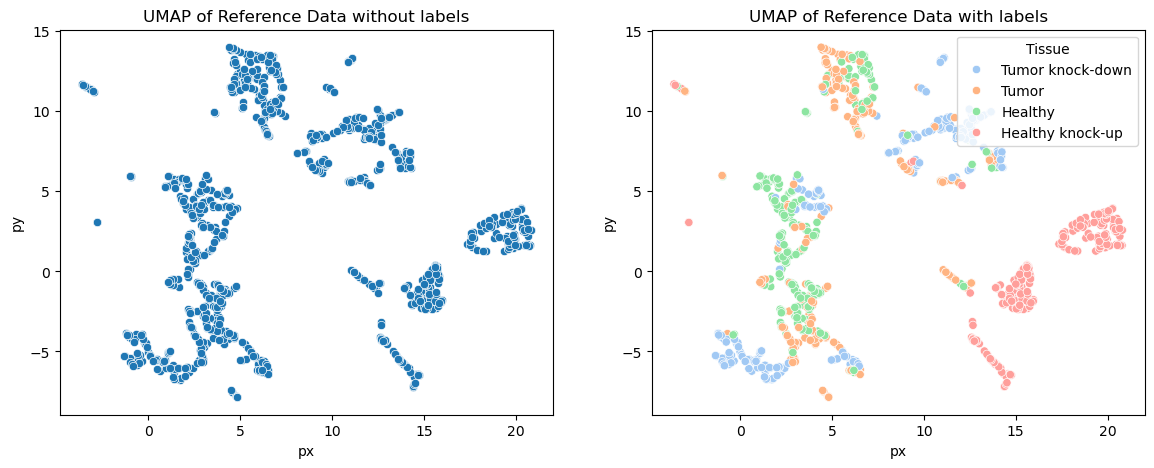

In [5]:
plot_df = pd.DataFrame(mapper.embedding_,columns=['px','py'])
labels = tissue_info[:len(embeddings)].values
correspondence = {0: "Healthy", 1: "Tumor", 2: "Healthy knock-up", 3: "Tumor knock-down"}
plot_df['Tissue'] = np.vectorize(correspondence.get)(labels)

# Create a matplotlib figure and axes
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

#plt.style.use("dark_background")

sns.scatterplot(data = plot_df,x='px',y='py',sizes=(50,200),ax=axs[0],palette="pastel")
axs[0].set_title('UMAP of Reference Data without labels')

sns.scatterplot(data = plot_df,x='px',y='py',hue='Tissue',sizes=(50,200),ax=axs[1],palette="pastel")
axs[1].set_title('UMAP of Reference Data with labels')

At first glance, the UMAP output is difficult to interpret, especially with four categories. However, we can somewhat distinguish two emerging categories.

## 4) t-SNE

In [6]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [7]:
standard_scaler = StandardScaler()

embeddings_normalized = standard_scaler.fit_transform(embeddings)

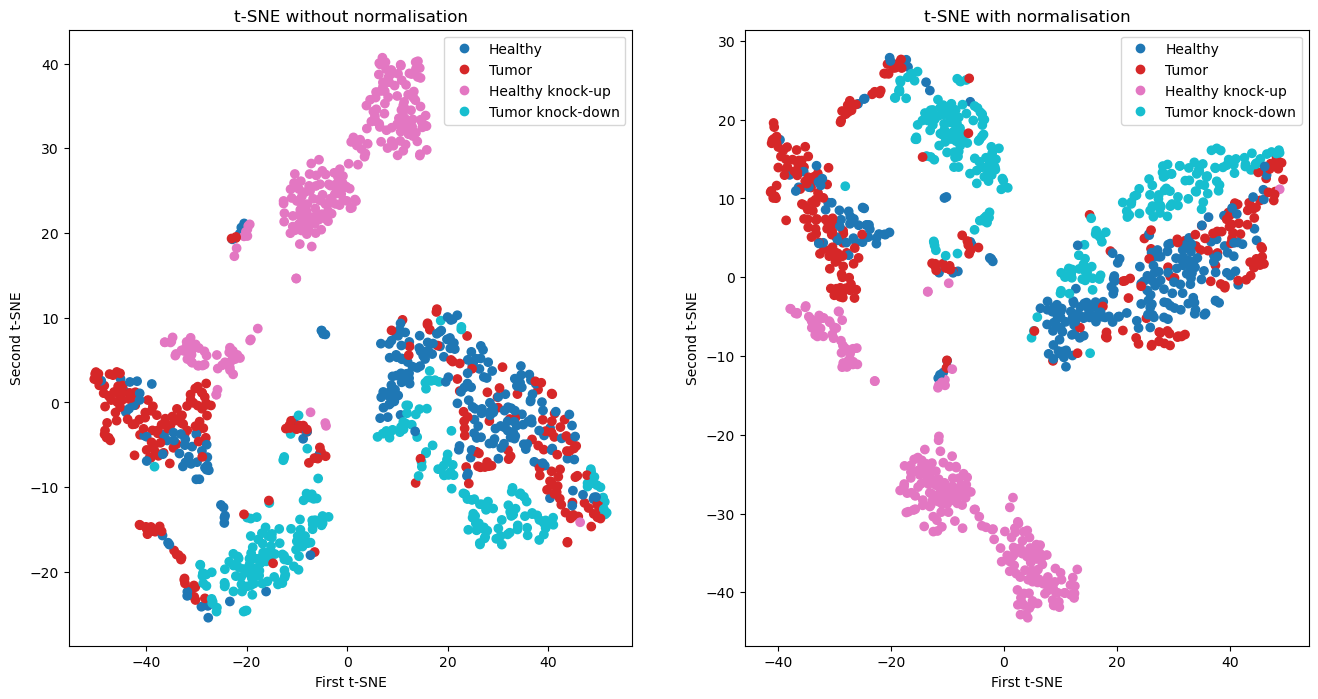

In [8]:
tsme = TSNE(n_components = 2).fit_transform(embeddings)
tsme_normalized = TSNE(n_components = 2).fit_transform(embeddings_normalized)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

_scatter = ax1.scatter(tsme[:, 0], tsme[:, 1], c=labels, cmap='tab10')
ax1.set_title("t-SNE without normalisation")
ax1.set_xlabel('First t-SNE')
ax1.set_ylabel('Second t-SNE')
legend_labels = ["Healthy", "Tumor", "Healthy knock-up", "Tumor knock-down"] 
_handles, _ = _scatter.legend_elements()
ax1.legend(_handles, legend_labels)

_scatter = ax2.scatter(tsme_normalized[:, 0], tsme_normalized[:, 1], c=labels, cmap='tab10')
ax2.set_title("t-SNE with normalisation")
ax2.set_xlabel('First t-SNE')
ax2.set_ylabel('Second t-SNE')
legend_labels = ["Healthy", "Tumor", "Healthy knock-up", "Tumor knock-down"] 
_handles, _ = _scatter.legend_elements()
ax2.legend(_handles, legend_labels)

plt.show()

I think the t-SNE is more conclusive than the UMAP, here we cleary see two groups. Normalisation, as I expected doesn't seem to affect much.

### KNN

In [9]:
modified_embeddings = embeddings.copy()
modified_labels = labels.copy()
for i in range(len(labels) - 1, -1, -1):
    if labels[i] >= 2:
        modified_labels = np.delete(modified_labels, i, axis=0)
        modified_embeddings = np.delete(modified_embeddings, i, axis=0)
print(len(modified_embeddings))
print(len(modified_labels))

503
503


In [10]:
# Cosine similarity
neigh = KNeighborsClassifier(n_neighbors=5, metric='cosine')
neigh.fit(modified_embeddings, modified_labels.ravel())

KNeighborsClassifier(metric='cosine')

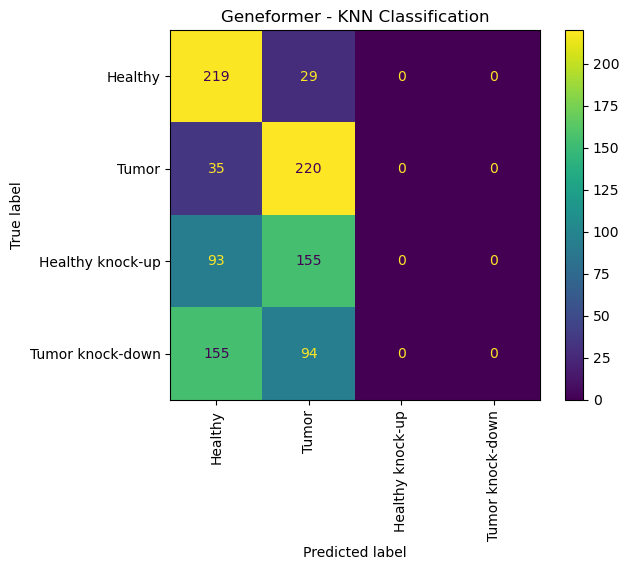

In [11]:
pred_labels = neigh.predict(embeddings)
cm = confusion_matrix(labels, pred_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Healthy", "Tumor", "Healthy knock-up", "Tumor knock-down"] )
disp.plot(xticks_rotation="vertical")
plt.title("Geneformer - KNN Classification")
plt.show()